# 1 - Data Preprocessing

## 1.1. Download Dataset

In [0]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1vF3FqgBC1Y-RPefeVmY8zetdZG1jmHzT'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_train.csv')

id = '1XhaV8YMuQeSwozQww8PeyiWMJfia13G6'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_test.csv')

import pandas as pd
df_train = pd.read_csv("imdb_train.csv")
df_test = pd.read_csv("imdb_test.csv")

reviews_train = df_train['review'].tolist()
sentiments_train = df_train['sentiment'].tolist()
reviews_test = df_test['review'].tolist()
sentiments_test = df_test['sentiment'].tolist()

print("Training set number:",len(reviews_train))
print("Testing set number:",len(reviews_test))

Training set number: 25000
Testing set number: 25000


## 1.2. Preprocess data

To preprocess data, regrex expression is used for remove tags such as '\<br />', etc. Besides, all characters are changed to their lower case which can reduce the repeatness of vocabulary. For tags including 'pos' and 'neg', the label encoder transforms them into 0 and 1. 0 and 1 make the correctness can be easily computed. 

In [0]:
import re

# remove tags such as '<br />' using regular expression
reg1 = re.compile("[.;:!\'?,\"()\[\]]")
reg2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def clean_reviews(reviews):
  # reduce all letters to lower case
  reviews = [reg1.sub("", line.lower()) for line in reviews]
  reviews = [reg2.sub(" ", line) for line in reviews]
  return reviews

reviews_train_clean = clean_reviews(reviews_train)
reviews_test_clean = clean_reviews(reviews_test)

In [0]:
print(reviews_train_clean[0])

i enjoyed this movie havent seen andy griffith in ages and felt he fit this role perfectly ive associated him with comedy but am pleased to see that hes versatile i wasnt troubled that dottys anxiety disorder may not have been verbatim from a psychiatric textbook there are zillions of whatever phobias and neuroses and these can take on a broad variety of quantitative and qualitative forms she is clearly a sensitive with extra sensory powers as was understood by the local indians but not by any anglos it is not surprising that this character is vulnerable and nominally eccentric although this is taken to be a light family movie it is actually more sophisticated than it seems also hirams twist at the end came as a pleasant surprise to me and tied all the preceding action together in a bundle its fun to contemplate the possibility of such spiritual guidance


In [0]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(sentiments_train+sentiments_test)
print(label_encoder.classes_)

labels_train = label_encoder.transform(sentiments_train)
labels_test = label_encoder.transform(sentiments_test)

['neg' 'pos']


In [0]:
print(sentiments_train[:8])
print(labels_train[:8])

['pos', 'pos', 'pos', 'neg', 'neg', 'neg', 'pos', 'pos']
[1 1 1 0 0 0 1 1]


In [0]:
label_dict = {0: 'neg', 1: 'pos'}
print(label_dict[0], label_dict[1])

neg pos


# 2 - Model Implementation

## 2.1. Word Embeddings

For word embeddings, word2vec with CBOW is implemented. One main reason to choose word2vec-CBOW is that it uses 'sum' on the results of embedding outputs, which would make it faster than skip-gram. Skip-gram may work better on some uncommon words, but the GPU resource is limited on Colab, saving time is significant.

### 2.1.1. Data Preprocessing for Word Embeddings

The techniques used on data preprocessing for word embeddings are tokenization, removing common stop words and punctuations. These techniques split the review into single words and make the vocabulary size smaller, which can save some time. In the mean time, a word list and a word-to-number dictionary are made for word embeding. Additionally, one-hot encoding would be excuted within the `nn.Embedding`. 

Both the training set and testing set are implemented to this model. In this case, the vocabulary becomes slightly lager and the size of data for model training is nearly doubled.

In [0]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords as sw

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
stop_words = set(sw.words('english'))

def tokenizer(review):
    review = word_tokenize(review)
    line = []
    for word in review:
        if word.isalpha() and word not in stop_words:
            line.append(word)
    
    return line

tokens_train = [tokenizer(w) for w in reviews_train_clean]
tokens_test = [tokenizer(w) for w in reviews_test_clean]

In [0]:
# make the word list
word_list = []
for tokens in tokens_train+tokens_test:
    word_list += [w for w in tokens]

# make a list of unique words
word_list = list(set(word_list))
word_list.sort() # avoid randomness

# make a word to number dictionary
voc_size = len(word_list)
word_dict = {w: i for i, w in enumerate(word_list)}

In [0]:
# Make cbow
window_size = 4 # set window size, 5 would be better but 4 already took a whole night to run
def make_cbow(dataset):
  cbow = []
  for review in dataset:
    for i in range(window_size, len(review)-window_size-1):
      target = word_dict[review[i]]
      context = review[i-window_size:i] + review[i+1:i+1+window_size]
      context = [word_dict[w] for w in context]
      cbow.append([context, target])
  
  return(cbow)

In [0]:
cbow_set = make_cbow(tokens_train+tokens_test)
print(cbow_set[:8])
print(len(cbow_set))

[[[36244, 76130, 50913, 101512, 48419, 2007, 40268, 41548], 4155], [[76130, 50913, 101512, 4155, 2007, 40268, 41548, 97213], 48419], [[50913, 101512, 4155, 48419, 40268, 41548, 97213, 85759], 2007], [[101512, 4155, 48419, 2007, 41548, 97213, 85759, 58916], 40268], [[4155, 48419, 2007, 40268, 97213, 85759, 58916, 6459], 41548], [[48419, 2007, 40268, 41548, 85759, 58916, 6459, 22115], 97213], [[2007, 40268, 41548, 97213, 58916, 6459, 22115, 87736], 85759], [[40268, 41548, 97213, 85759, 6459, 22115, 87736, 101437], 58916]]
5559092


### 2.1.2. Build Word Embeddings Model

The dimentions of word embedding is set to 256, which is slightly smaller than sqrt(voc_size). To reduce the running time and make the best use of every data, the model would iterate through all the data for 1 run. Also, a smaller learning rate may reduce the final loss but the learning rate is set to 0.01 which may fit the data a bit faster than a smaller learning rate.

In [0]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
learning_rate = 0.01 # could be a bit smaller
embedding_dim = 256
no_of_epochs = len(cbow_set)

In [0]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torch.optim as optim
import numpy as np
import torch.cuda

class CBOW(nn.Module):
  def __init__(self, voc_size, embedding_dim):
    super(CBOW, self).__init__()
    # embedding layer
    self.embeddings = nn.Embedding(voc_size, embedding_dim)
    # 2 linear layers
    self.linear1 = nn.Linear(embedding_dim, voc_size//embedding_dim)
    self.linear2 = nn.Linear(voc_size//embedding_dim, voc_size)

  def forward(self, x):
    embeds = sum(self.embeddings(x)).view(1,-1) # sum the embeds
    x = self.linear1(embeds)
    # use relu and log_softmax to normalize the outputs of 2 linear layer2
    x = F.relu(x)
    x = self.linear2(x)
    output = F.log_softmax(x, dim=1) # ouput is a series of probility of each word
    return output

### 2.1.3. Train Word Embeddings Model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

PATH = './drive/My Drive/btan4740_word.pt'

In [0]:
cbow_model = CBOW(voc_size=voc_size+1, embedding_dim=embedding_dim).to(device)
criterion = nn.NLLLoss()
optimiser = optim.SGD(cbow_model.parameters(), lr=learning_rate)

In [0]:
total_loss = 0
for epoch in range(0, no_of_epochs): # iterate through all the data, more runs could be better but more time it does require
  inputs_torch = torch.LongTensor(cbow_set[epoch][0]).to(device)
  label_torch = torch.LongTensor([cbow_set[epoch][1]]).to(device)

  cbow_model.train()

  optimiser.zero_grad()

  output = cbow_model(inputs_torch)

  #print(output)
  #print(label_torch)
  loss = criterion(output, label_torch)
  total_loss += loss.item()

  loss.backward()
  optimiser.step()

  if epoch % 250000  == 249999: 
      print('Epoch: %d, loss: %.4f' %(epoch + 1, total_loss/250000))
      total_loss = 0
      torch.save(cbow_model, PATH)

print('Epoch: %d, loss: %.4f' %(epoch + 1, loss))
print('training finished')

Epoch: 750000, loss: 9.0099


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CBOW. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1000000, loss: 9.0541
Epoch: 1250000, loss: 9.0165
Epoch: 1500000, loss: 8.9920
Epoch: 1750000, loss: 8.9760
Epoch: 2000000, loss: 8.9545
Epoch: 2250000, loss: 8.9169
Epoch: 2500000, loss: 8.9302
Epoch: 2750000, loss: 8.8976
Epoch: 3000000, loss: 8.9340
Epoch: 3250000, loss: 8.9030
Epoch: 3500000, loss: 8.9062
Epoch: 3750000, loss: 8.8865
Epoch: 4000000, loss: 8.9186
Epoch: 4250000, loss: 8.8779
Epoch: 4500000, loss: 8.8488
Epoch: 4750000, loss: 8.8495
Epoch: 5000000, loss: 8.8406
Epoch: 5250000, loss: 8.8387
Epoch: 5500000, loss: 8.8296
Epoch: 5559092, loss: 6.6299
training finished


### 2.1.4. Save Word Embeddings Model

In [0]:
torch.save(cbow_model, PATH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CBOW. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.1.5. Load Word Embeddings Model

In [0]:
cbow_model2 = torch.load(PATH)
cbow_model2 = cbow_model2.to(device)
cbow_model2.eval()

CBOW(
  (embeddings): Embedding(130260, 256)
  (linear1): Linear(in_features=256, out_features=508, bias=True)
  (linear2): Linear(in_features=508, out_features=130260, bias=True)
)

## 2.2. Character Embeddings

### 2.2.1. Data Preprocessing for Character Embeddings

For regularizing the input, the length of word is set to 16, which means every single word length will be transformed to exactlly 16. Due to the gates of LSTM, some important previous imformation inputed will not be easily 'forget' like RNN. Thanks to this feature, adding paddings after (not before) the characters of some words does not have much negative effect.

In [0]:
# make char table: character->number
char_arr = ['a', 'b', 'c', 'd', 'e', 'f', 'g',
            'h', 'i', 'j', 'k', 'l', 'm', 'n',
            'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z']
# the number start from '1' cuz '0' is took for err handling
char_dict = {n: i+1 for i, n in enumerate(char_arr)}
char_dict_size = len(char_dict)

# make train data: 16->1
char_emb_train = []
for word in word_list:
  char_seq = []
  # make sure all input size is exactly 16
  for char in word:
    if char in char_dict:
      char_seq.append(char_dict[char])
    else:
      # if char is not a english character, put a '0' instead
      char_seq.append(0)

    if len(char_seq) >= 16:
      break
  # fill '0' into char_seq until its length become 16
  if len(char_seq) < 16:
    temp_seq = [0] * (16 - len(char_seq))
    char_seq = char_seq + temp_seq 
    # putting '0's before the char_seq may be better for LSTM
    # since the imformation could be 'forget' (actually it's a drawback of RNN, not LSTM)
    # but the result turned out to be not really bad
    # one reason could be the 'gates' of LSTM, the previous important imformation is remembered
    # and also, 16 is not really long :D
    # so just let it be like this

  char_emb_train.append([char_seq, word_dict[word]])

print(char_emb_train[:8])

[[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0], [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1], [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8], 2], [[1, 1, 1, 1, 1, 1, 1, 1, 18, 7, 8, 0, 0, 0, 0, 0], 3], [[1, 1, 1, 1, 1, 1, 1, 8, 0, 0, 0, 0, 0, 0, 0, 0], 4], [[1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 7, 7, 7], 5], [[1, 1, 1, 1, 1, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0], 6], [[1, 1, 1, 1, 1, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 7]]


In [0]:
# make batch: randomly choose data from dataset
def char_encoder(char_input):
  temp = [0] * (char_dict_size + 1)
  temp[char_input] = 1
  return temp

# make a dictionary for character vector
char_vec = {char_dict[c]: char_encoder(char_dict[c]) for c in char_arr}
char_vec[0] = [1] + ([0] * char_dict_size)
print(char_vec)

# randomly choose data as member of batch
def batch_prep(dataset, batch_size):
  input_batch = []
  target_batch = []
  random_index = np.random.choice(range(len(dataset)), batch_size, replace=True)

  for i in random_index:
    input_batch.append([char_vec[c] for c in dataset[i][0]])
    target_batch.append(dataset[i][1])

  return np.array(input_batch), np.array(target_batch)

{1: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 3: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 4: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 5: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 6: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 7: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 8: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 11: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 12: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

### 2.2.2. Build Character Embeddings Model

LSTM is used here for character embedding, as mentioned before, the feature of long-short term memmory does help to reduce the influence of vanishing gradient problem. As for hyperparameters, because this model runs fast, the learning rate is set to 0.005, and the epoch is a bit large which is related to the size of batch and dataset (basicly each characters-to-word set will be trained 32 times on average). The predicting accuracy turned to be satisfying.

In [0]:
# Setting hyperparameters
batch_size = 512
learning_rate = 0.005
n_hidden = 256
total_epoch = int(len(char_emb_train) / batch_size * 32)

# Number of sequences (length of word)
n_step = 16

# number of inputs (dimension of input vector) = 27 (one more for err)
n_input = 27
# number of classes
n_class = voc_size

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True)
    self.linear = nn.Linear(n_hidden, n_class)

  def forward(self, x):        
    # lstm layer
    x,_ = self.lstm(x)
    # linear layer
    x = self.linear(x[:,-1,:]) # only take the last state as prediction
    # softmax layer
    x = F.log_softmax(x, dim=1)
    return x

### 2.1.4. Train Character Embeddings Model

In [0]:
net = Net().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [0]:
for epoch in range(total_epoch):

  input_batch, target_batch = batch_prep(char_emb_train, batch_size)
  input_batch_torch = torch.from_numpy(input_batch).float().to(device)
  target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device)

  net.train()
  outputs = net(input_batch_torch)
  loss = criterion(outputs, target_batch_torch)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  
  if epoch % 1000 == 999:
    net.eval()
    outputs = net(input_batch_torch) 
    train_loss = criterion(outputs, target_batch_torch)
    _, predicted = torch.max(outputs, 1)
    train_acc= accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())

    print('Epoch: %d, train loss: %.5f, train_acc: %.4f'%(epoch + 1, train_loss.item(), train_acc))

Epoch: 1000, train loss: 6.91362, train_acc: 0.0918
Epoch: 2000, train loss: 1.76951, train_acc: 0.6152
Epoch: 3000, train loss: 0.52696, train_acc: 0.8594
Epoch: 4000, train loss: 0.21255, train_acc: 0.9570
Epoch: 5000, train loss: 0.19624, train_acc: 0.9570
Epoch: 6000, train loss: 0.20900, train_acc: 0.9590
Epoch: 7000, train loss: 0.13306, train_acc: 0.9746
Epoch: 8000, train loss: 0.09582, train_acc: 0.9766


### 2.1.5. Save Character Embeddings Model

In [0]:
PATH2 = './drive/My Drive/btan4740_character.pt'

In [0]:
drive.mount('/content/drive')
#torch.save(net, PATH2)

### 2.1.6. Load Character Embeddings Model

In [0]:
char_emb_model = torch.load(PATH2)
char_emb_model = char_emb_model.to(device)
char_emb_model.eval()

Net(
  (lstm): LSTM(27, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=130259, bias=True)
)

In [0]:
input_batch, _ = batch_prep(char_emb_train, 1)
input_batch_torch = torch.from_numpy(input_batch).float().to(device)
output = char_emb_model(input_batch_torch)

In [0]:
_, pred = torch.max(output, 1)
print(pred)

tensor([100476], device='cuda:0')


## 2.3. Sequence model

The sequence model is basicly a LSTM with an embedding layer. This model directly copy the embedding layer of previous word embedding model.

### 2.3.1. Apply/Import Word Embedding and Character Embedding Model

The character embedding model is applied as translator to predict the words from both training set and test set. And each review are changed to exactly 256-word long (adding empty words before reviews or cutting down the sentences).

Why not transform all reviews to number sequences and then generate batches through `Dataloader`? It could be done if there is no disconection issue (wasted a lot of time on it) and this would save a lot of training time. If the code ran locally, I will do this (actually I could have done the prediction locally and upload the processed data but I did not realized it).

In [0]:
# set max length
MAX_LENGTH = 256

def word_pred(word):
  vec_temp = []
  #print(word)
  # transform characters into numbers
  # if not character, just put char_vec[0] instead
  for ch in word:
    if ch in char_arr:
      vec_temp.append(char_vec[char_dict[ch]])    
    else:
      vec_temp.append(char_vec[0])

    if len(vec_temp) >= 16:
      break
  # regularize the length of every word to 16
  if len(vec_temp) < 16:
    for i in range(16-len(vec_temp)):
      vec_temp.append(char_vec[0])

  vec_temp = np.array([vec_temp])
  #print(vec_temp)

  # predict the word through character embedding model
  input_torch = torch.from_numpy(vec_temp).float().to(device)
  output = char_emb_model(input_torch)
  _, pred = torch.max(output, 1)
  pred = pred.cpu().tolist()

  return pred[0]

def padding_filter(line, voc_size, max_length):
  line_temp = []
  for i in range(max_length - len(line)):
    line_temp.append(voc_size)

  return line_temp+line

# transform review into a sequence of numbers predicted by character embedding model
def seq_prep(review, voc_size, max_length):
  line = []
  for word in review:
    pred = word_pred(word)
    line.append(pred)
    
    if len(line) >= max_length:
      break
  
  if len(line) < max_length:
    line = padding_filter(line, voc_size, max_length)

  return line

In [0]:
seq_prep(tokens_train[0], voc_size, MAX_LENGTH)

In [0]:
# prepare batch
# choose randoml reviews as inputs
def batch_prep2(dataset_X, dataset_y, batch_size):
  inputs_batch = []
  labels_batch = []
  random_index = np.random.choice(range(len(dataset_X)), batch_size, replace=True)

  for i in random_index:
    inputs_batch.append(seq_prep(dataset_X[i], voc_size, MAX_LENGTH))
    labels_batch.append(dataset_y[i])

  return inputs_batch, labels_batch

In [0]:
batch_prep2(tokens_train, labels_train, 1)

### 2.3.2. Build Sequence Model

The learning rate is 0.001 according to the total epoch and batch_size. For each epoch, a batch of 128 reviews would be randomly selected from the training set.

The main difference between the sequence model and the character embedding model is the embedding layer copied from word2vec-CBOW model.

In [0]:
learning_rate = 0.001
tagset_size = 2
hidden_dim = 256
batch_size = 128

In [0]:
class SeqTagger(nn.Module):

  def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
    super(SeqTagger, self).__init__()
    self.hidden_dim = hidden_dim
    # embedding layer, the size is the same as word2vec-CBOW model
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    # LSTM
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True) 
    # LSTM to tag
    self.hidden2tag = nn.Linear(hidden_dim, tagset_size)


  def forward(self, sentence):
    embeds = self.word_embeddings(sentence)
    lstm_out, _ = self.lstm(embeds)
    # only select the last state of LSTM
    tag_space = self.hidden2tag(lstm_out[:,-1,:])
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

In [0]:
seq_model = SeqTagger(embedding_dim, hidden_dim, voc_size+1, tagset_size).to(device)
seq_model.word_embeddings = cbow_model2.embeddings
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(seq_model.parameters(), lr=learning_rate)

### 2.3.3. Train Sequence Model

In [0]:
loss_now = 0.0
for epoch in range(400):  
  # total epoch could be larger if more time and GPU resources were available
  X, y = batch_prep2(tokens_train, labels_train, batch_size)
  sentences = torch.LongTensor(X).to(device)
  labels = torch.tensor(y).view(-1).to(device)

  seq_model.zero_grad()
  seq_model.train()
  tag_scores = seq_model(sentences)
  
  # loss calculate and backward
  loss = loss_function(tag_scores, labels.view(-1))
  loss.backward()
  optimizer.step()

  loss_now+=loss.item()
  
  if epoch % 20 == 19: 
    seq_model.eval()
    tag_scores = seq_model(sentences)
    _, predicted = torch.max(tag_scores, 1)
    train_acc= accuracy_score(predicted.cpu().numpy(), labels.view(-1).cpu().numpy())
    # print the average loss of last 20 epoch and the accuracy of this epoch
    print('Epoch: %d, training loss: %.4f, training acc: %.2f'%(epoch+1, loss_now/20, train_acc))
    loss_now = 0.0

Epoch: 260, training loss: 0.0805, training acc: 0.74
Epoch: 280, training loss: 0.5093, training acc: 0.73
Epoch: 300, training loss: 0.4410, training acc: 0.80
Epoch: 320, training loss: 0.3671, training acc: 0.79
Epoch: 340, training loss: 0.3301, training acc: 0.83
Epoch: 360, training loss: 0.3230, training acc: 0.92
Epoch: 380, training loss: 0.2873, training acc: 0.88
Epoch: 400, training loss: 0.2873, training acc: 0.84


### 2.3.4. Save Sequence Model

In [0]:
PATH3 = './drive/My Drive/btan4740_sequence.pt'

In [0]:
torch.save(seq_model, PATH3)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SeqTagger. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.3.5. Load Sequence Model

In [0]:
seq_model2 = torch.load(PATH3)
seq_model2 = seq_model2.to(device)

# 3 - Evaluation

## 3.1. Performance Evaluation


A table with precision, recall, f1 of test set is provided and one batch of 1280 random cases (not the whole set, mainly for save time because the sequence generator runs really slow) from test set are selected for testing.

In [0]:
X, y = batch_prep2(tokens_test, labels_test, 1280)
sentences = torch.LongTensor(X).to(device)
labels = torch.tensor(y).view(-1).to(device)

In [0]:
seq_model2.eval()

tag_scores = seq_model2(sentences)
_, predicted = torch.max(tag_scores, 1)
y_pred = predicted.cpu().numpy()
y_true = labels.view(-1).cpu().numpy()

In [0]:
"""
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
"""
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8337    0.6305    0.7180       636
           1     0.7059    0.8758    0.7817       644

    accuracy                         0.7539      1280
   macro avg     0.7698    0.7531    0.7498      1280
weighted avg     0.7694    0.7539    0.7500      1280



## 3.2. Hyperparameter Testing

The batch size is different from training process (128->1280), so the epoch is reduced. And the learning rate is the same as it in training process.

In [0]:
learning_rate = 0.001
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(seq_model2.parameters(), lr=learning_rate)

In [0]:
from sklearn.metrics import f1_score

f1s = []
for epoch in range(20):  
  X, y = batch_prep2(tokens_test, labels_test, 1280)
  sentences = torch.LongTensor(X).to(device)
  labels = torch.tensor(y).view(-1).to(device)

  seq_model2.zero_grad()
  seq_model2.train()
  tag_scores = seq_model2(sentences)
  
  # loss calculate and backward
  loss = loss_function(tag_scores, labels.view(-1))
  loss.backward()
  optimizer.step()

  seq_model2.eval()
  tag_scores = seq_model2(sentences)
  _, predicted = torch.max(tag_scores, 1)
  y_pred = predicted.cpu().numpy()
  y_true = labels.view(-1).cpu().numpy()
  # get f1 scores
  f1 = f1_score(y_true, y_pred)
  f1s.append((epoch, f1))

In [0]:
print(f1s)

[(0, 0.7669819432502148), (1, 0.7567114093959731), (2, 0.7818028643639426), (3, 0.8438880706921944), (4, 0.8395802098950526), (5, 0.8302493966210781), (6, 0.8283642224012894), (7, 0.839622641509434), (8, 0.8305489260143198), (9, 0.845872899926954), (10, 0.8524833209785027), (11, 0.8595548733691482), (12, 0.845360824742268), (13, 0.8601798855273917), (14, 0.8477034649476229), (15, 0.8514548238897396), (16, 0.8487261146496815), (17, 0.8661764705882353), (18, 0.8639344262295081), (19, 0.8704422032583398)]


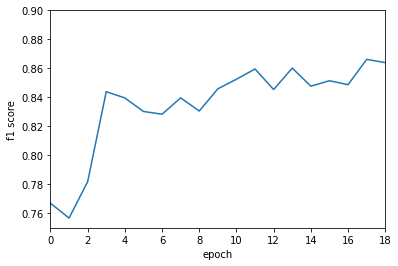

In [0]:
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
%matplotlib inline

Xs = []
Ys = []
for point in f1s:
  x, y = point
  Xs += [x]
  Ys += [y]

Xs = np.array(Xs, dtype=int)
Ys = np.array(Ys)

plt.figure()
plt.xlim((0, 18))
plt.ylim((0.75, 0.9))
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.plot(Xs, Ys)
plt.show()

The figure shows that with the learning rate 0.001, since epoch 11 the f1 socre tends to be stable.

# Summary
The model could be improved (hyperparameters, network size); the preprocessing techniques could be furtherly optimized, such as merging different tenses for the same word; and some mistakes, such as adding padding after the characters in character embedding, should be avoid.